Found 20638 files belonging to 15 classes.
Classes found: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 520s 764ms/step - accuracy: 0.2570 - loss: 2.2361 - val_accuracy: 0.5371 - val_loss: 1.4803
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 389s 752ms/step - accuracy: 0.6461 - loss: 1.0401 - val_accuracy: 0.6655 - val_loss: 0.9588
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 378s 732ms/step - accuracy: 0.7695 - loss: 0.6716 - val_accuracy: 0.7046 - val_loss: 0.8910
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 379s 734ms/step - accuracy: 0.8213 - loss: 0.5157 - val_accuracy: 0.8193 - val_loss: 0.5115
Epoch 

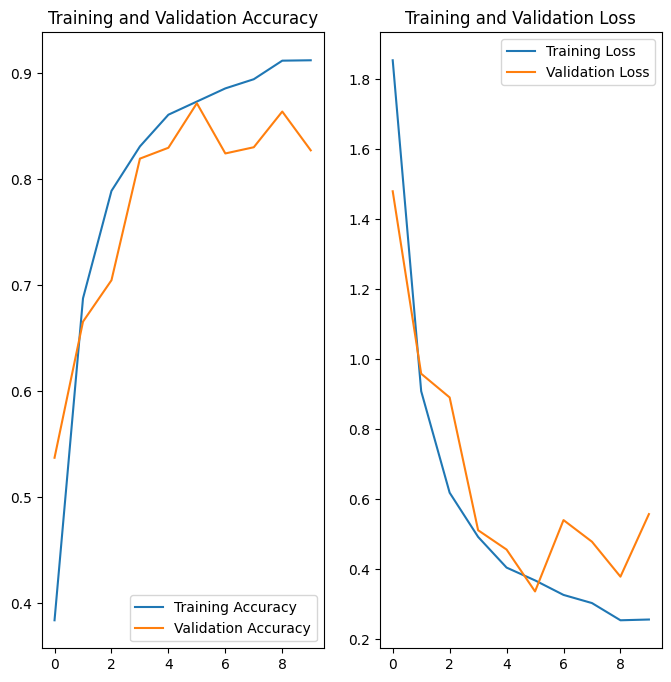

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


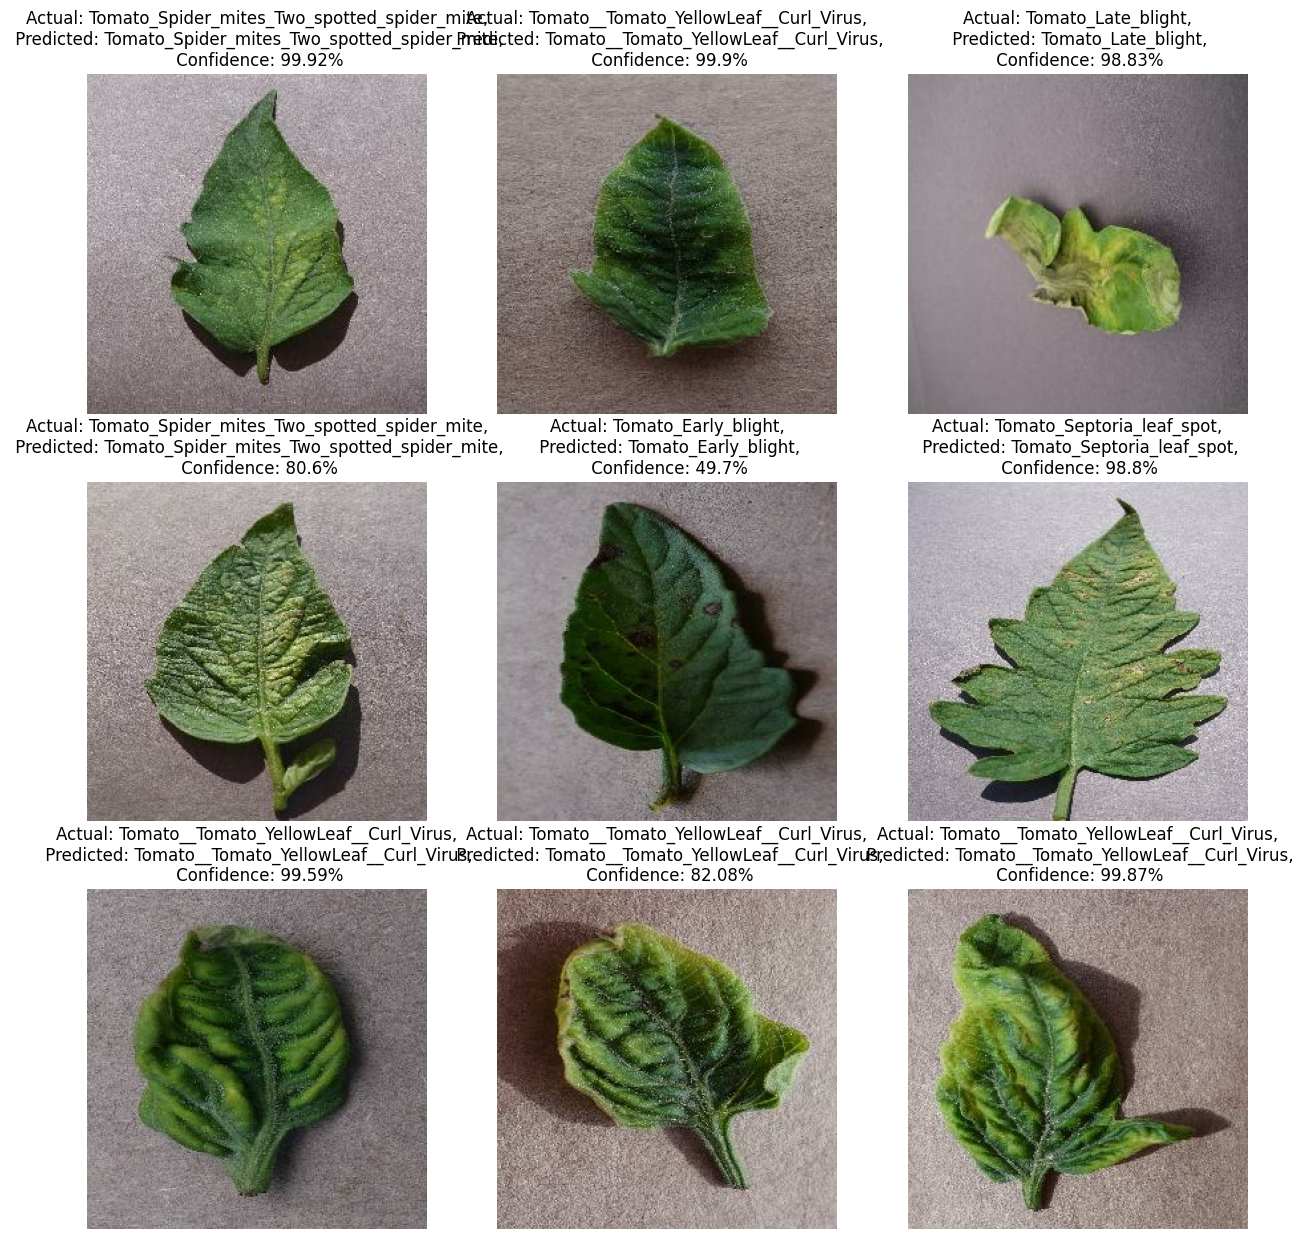

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# Set constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10

# Load and Split Dataset
def load_and_split_dataset(dataset_directory, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_directory,
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )
    
    class_names = dataset.class_names
    print(f"Classes found: {class_names}")
    
    ds_size = len(dataset)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Resize and Rescale Layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

# Build Model
def build_model(input_shape, n_classes):
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    return model

# Train the Model
def train_model(model, train_ds, val_ds):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    return history

# Plot Accuracy and Loss Curves
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Evaluate Model
def evaluate_model(model, test_ds):
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test accuracy: {test_acc * 100:.2f}%")

# Prediction Function
def predict(model, img, class_names):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Main Script
if __name__ == "__main__":
    dataset_directory = "PlantVillage"  # Update with your dataset path
    
    # Load and split dataset
    train_ds, val_ds, test_ds, class_names = load_and_split_dataset(dataset_directory)
    
    # Build and compile model
    input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    n_classes = len(class_names)
    model = build_model(input_shape, n_classes)
    
    # Train the model
    history = train_model(model, train_ds, val_ds)
    
    # Evaluate the model on the test set
    evaluate_model(model, test_ds)
    
    # Plot accuracy and loss curves
    plot_training_history(history)
    
    # Run prediction on a sample image from the test set
    plt.figure(figsize=(15, 15))
    for images, labels in test_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            predicted_class, confidence = predict(model, images[i].numpy(), class_names)
            actual_class = class_names[labels[i]]
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
            plt.axis("off")
    plt.show()
